2025-01-02 16:50:52 [INFO] DistilbertImdbFinetuning - 디바이스 설정: mps
디바이스 설정: mps
Using cache found in /Users/soojin/.cache/torch/hub/huggingface_pytorch-transformers_main
2025-01-02 16:50:53 [INFO] DistilbertImdbFinetuning - DistilBERT 토크나이저 로드 완료 (소요시간: 1.15초)
DistilBERT 토크나이저 로드 완료 (소요시간: 1.15초)
2025-01-02 16:50:57 [INFO] DistilbertImdbFinetuning - IMDb 데이터셋 로드 완료 (소요시간: 3.92초)
IMDb 데이터셋 로드 완료 (소요시간: 3.92초)
2025-01-02 16:50:57 [INFO] DistilbertImdbFinetuning - DataLoader 준비 완료 (Train: 25000개, Test: 25000개)
DataLoader 준비 완료 (Train: 25000개, Test: 25000개)
Using cache found in /Users/soojin/.cache/torch/hub/huggingface_pytorch-transformers_main
2025-01-02 16:50:58 [INFO] DistilbertImdbFinetuning - DistilbertTextClassifier 생성 및 인코더 파라미터 동결 완료.
DistilbertTextClassifier 생성 및 인코더 파라미터 동결 완료.
2025-01-02 16:50:58 [INFO] DistilbertImdbFinetuning - 학습 준비: Loss=BCEWithLogitsLoss(), LR=0.001, Epoch=3
학습 준비: Loss=BCEWithLogitsLoss(), LR=0.001, Epoch=3
2025-01-02 16:50:58 [INFO] DistilbertImdbFinetun

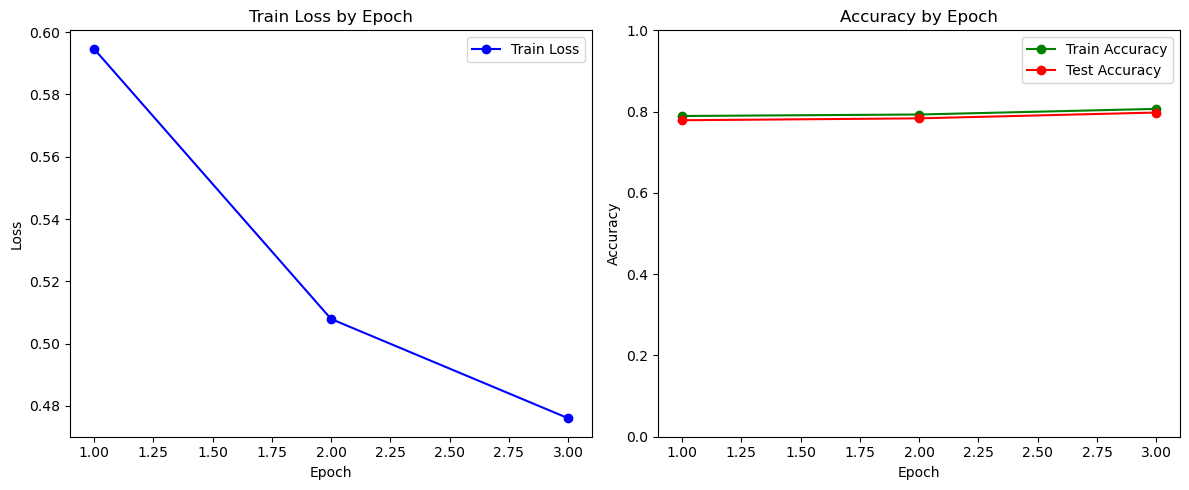

2025-01-02 17:50:11 [INFO] DistilbertImdbFinetuning - 그래프 시각화 완료. Weights & Biases 대시보드에서 추가 분석이 가능합니다.
그래프 시각화 완료. Weights & Biases 대시보드에서 추가 분석이 가능합니다.


In [4]:
"""
이 코드는 사전 학습된 DistilBERT를 이용해 IMDb 영화 리뷰 데이터셋을 감정 분석(긍정/부정)하는 예제입니다.

*초기 세팅 및 로거 설정 등에 대한 설명은 간략히 하고, 
 'collateFunction' 및 핵심 로직(Tokenizer 처리, 모델 학습 루프) 부분에 자세한 설명을 추가했습니다.*

[전체 요약 흐름]
1) DistilBERT 토크나이저를 불러와, IMDb 리뷰 텍스트를 토큰 인덱스로 변환  
2) DataLoader 구성 -> 텍스트 + 레이블(0/1) -> (input_ids, label) 텐서  
3) 사전 학습된 DistilBERT 모델(Encoder) + 분류 레이어(Linear(768->1))를 정의  
4) DistilBERT는 Freeze (파라미터 동결), 마지막 레이어만 학습  
5) 각 Epoch별로 손실(Loss), 정확도(Accuracy)를 측정하고 기록(로깅)  
6) Matplotlib로 학습 추이를 시각화  

"""

import logging
import time
import wandb
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.optim import Adam
from torch.utils.data import DataLoader
from datasets import load_dataset
from tqdm import tqdm

# -----------------------------------
# (1) 로깅 설정
# -----------------------------------
logger = logging.getLogger("DistilbertImdbFinetuning")
logger.setLevel(logging.INFO)
consoleHandler = logging.StreamHandler()
consoleHandler.setLevel(logging.INFO)
logger.addHandler(consoleHandler)

# (W&B 초기화)
wandb.init(project="Distilbert-Imdb-Finetuning", name="distilbert-imdb-run")

# -----------------------------------
# (2) 디바이스 선택 (Mac MPS)
# -----------------------------------
device = "mps"

# -----------------------------------
# (3) DistilBERT Tokenizer 로드
# -----------------------------------
tokenizerLoadStart = time.time()
distilbertTokenizer = torch.hub.load(
    'huggingface/pytorch-transformers',
    'tokenizer',
    'distilbert-base-uncased'
)
tokenizerLoadEnd = time.time()
logger.info(f"DistilBERT 토크나이저 로드 완료 (소요시간: {tokenizerLoadEnd - tokenizerLoadStart:.2f}초)")

# -----------------------------------
# (4) IMDb 데이터셋 로드
# -----------------------------------
imdbLoadStart = time.time()
imdbDataset = load_dataset("stanfordnlp/imdb")
imdbLoadEnd = time.time()
logger.info(f"IMDb 데이터셋 로드 완료 (소요시간: {imdbLoadEnd - imdbLoadStart:.2f}초)")

# -----------------------------------
# (5) DataLoader 구성
#       - collateFunction에서 핵심 로직 설명
# -----------------------------------
def collateFunction(batch):
    """
    IMDb 'batch'를 받아 (텍스트, 레이블)을 추출하고
    DistilBERT 토크나이저로 인덱싱하여 텐서 형태로 반환합니다.

    - maximumTokenLength (int):
        한 문장을 토큰화했을 때, 최대 몇 개의 토큰까지 사용할지 정합니다.
        400으로 설정하면, 400개 토큰을 넘어서는 부분은 잘려(truncation) 버립니다.
        지나치게 큰 값을 주면 메모리 낭비가 생길 수 있고,
        지나치게 작으면 중요한 정보가 잘려나갈 수 있습니다.

    - batch에는 여러 샘플이 포함됩니다.
      예: [{"text": "영화가 재미없어요..", "label": 0},
           {"text": "이건 정말 최고!", "label": 1}, ...]

    - textList와 labelList:
        batch의 각 샘플에서
         - "text" 키 -> 실제 리뷰 문장 (str)
         - "label" 키 -> 감정 레이블(0=부정, 1=긍정)
        를 추출해서 각각 리스트에 모읍니다.

    - distilbertTokenizer(..., padding=True, truncation=True, max_length=400):
        1) padding=True
           : 한 배치 내에서 가장 긴 문장 길이에 맞춰
             나머지 짧은 문장은 [PAD] 토큰 등으로 길이를 맞춥니다.
        2) truncation=True
           : 최대 길이를 초과하면 뒷부분을 잘라냅니다.
        3) max_length=400
           : 최대 400 토큰까지만 사용합니다.

        반환 결과 (encodedBatch)는 딕셔너리 형태이며,
         - encodedBatch['input_ids']: 실제 토큰 인덱스 목록 (2D)
         - (주의) attention_mask도 생성되지만,
           여기서는 주로 input_ids만 사용합니다 (필요하다면 attention_mask도 추출 가능).

    - 최종적으로 
       - inputIdsTensor: shape (batch_size, sequence_length)
       - labelsTensor: shape (batch_size)
      를 반환합니다.
    """
    maximumTokenLength = 400

    textList = []   # 리뷰 텍스트들의 목록
    labelList = []  # 해당 리뷰의 레이블(0/1) 목록

    # batch 안에는 여러 샘플(dict)이 있음
    for row in batch:
        # row['label']: 0 또는 1
        labelList.append(row['label'])
        # row['text']: 실제 영화 리뷰 문자열
        textList.append(row['text'])

    # 여러 리뷰를 한 번에 tokenizer 처리
    encodedBatch = distilbertTokenizer(
        textList,
        padding=True,       # 배치 내 가장 긴 리뷰에 맞춰 패딩
        truncation=True,    # 너무 긴 문장은 잘라냄
        max_length=maximumTokenLength
    )

    # input_ids만 LongTensor로 변환
    inputIdsTensor = torch.LongTensor(encodedBatch['input_ids'])
    # 레이블도 LongTensor
    labelsTensor = torch.LongTensor(labelList)

    return inputIdsTensor, labelsTensor

trainDataLoader = DataLoader(
    imdbDataset['train'],
    batch_size=64,
    shuffle=True,
    collate_fn=collateFunction
)
testDataLoader = DataLoader(
    imdbDataset['test'],
    batch_size=64,
    shuffle=False,
    collate_fn=collateFunction
)
logger.info(f"DataLoader 준비 완료 (Train: {len(imdbDataset['train'])}개, Test: {len(imdbDataset['test'])}개)")

# -----------------------------------
# (6) 모델 정의 (DistilBERT + Linear)
# -----------------------------------
class DistilbertTextClassifier(nn.Module):
    """
    DistilBERT 인코더 + 
    마지막에 1차원 출력(이진 분류용) Linear 레이어
    """
    def __init__(self):
        super().__init__()
        # 사전 학습된 DistilBERT 모델(Encoder) 로드
        self.distilbertEncoder = torch.hub.load(
            'huggingface/pytorch-transformers',
            'model',
            'distilbert-base-uncased'
        )
        # DistilBERT 결과(last_hidden_state)의 [CLS] 위치(0번째)만 가져와
        # 이진 분류용으로 연결 -> Linear(768 -> 1)
        self.classifierLayer = nn.Linear(768, 1)

    def forward(self, inputIds):
        # DistilBERT 모델에 인덱스 텐서 전달
        outputs = self.distilbertEncoder(inputIds)
        # 'last_hidden_state' shape = [batch_size, seq_len, 768]
        hiddenStates = outputs['last_hidden_state']
        # [CLS] 위치 (인덱스 0)
        clsEmbedding = hiddenStates[:, 0, :]
        # 최종적으로 Linear 통과 -> 로짓 (크기 [batch_size, 1])
        logits = self.classifierLayer(clsEmbedding)
        return logits

distilbertTextClassifier = DistilbertTextClassifier()

# DistilBERT 파라미터는 Freeze (encoder 부분 업데이트 X)
for param in distilbertTextClassifier.distilbertEncoder.parameters():
    param.requires_grad = False

distilbertTextClassifier = distilbertTextClassifier.to(device)
logger.info("DistilbertTextClassifier 생성 및 인코더 파라미터 동결 완료.")

# W&B 모델 추적
wandb.watch(distilbertTextClassifier, log="all")

# -----------------------------------
# (7) 학습 준비
# -----------------------------------
modelLossFunction = nn.BCEWithLogitsLoss()
learningRate = 0.001
optimizer = Adam(distilbertTextClassifier.parameters(), lr=learningRate)
epochCount = 3

logger.info(f"학습 준비: Loss={modelLossFunction}, LR={learningRate}, Epoch={epochCount}")

# -----------------------------------
# (8) 정확도 계산 함수
# -----------------------------------
def calculateAccuracy(model, dataLoader):
    """
    모델의 로짓이 0보다 크면 긍정(1), 작으면 부정(0)이라 가정하고,
    실제 정답(label)과 비교해 정확도를 계산
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputIdsTensor, labelsTensor in dataLoader:
            inputIdsTensor = inputIdsTensor.to(device)
            labelsTensor = labelsTensor.to(device)

            outputs = model(inputIdsTensor)      # [batch_size, 1]
            predictions = (outputs > 0).long()   # True->1, False->0
            predictions = predictions[..., 0]    # shape [batch_size]

            total += labelsTensor.size(0)
            correct += (predictions == labelsTensor).sum().item()

    return correct / total

# -----------------------------------
# (9) 학습 루프 (에폭별 로그)
#    - 배치 단위 로그는 최소화
# -----------------------------------
trainLossList = []
trainAccuracyList = []
testAccuracyList = []

overallStartTime = time.time()
logger.info("학습 시작...")

for epochIndex in range(epochCount):
    logger.info(f"==== 에폭 {epochIndex+1}/{epochCount} 시작 ====")
    epochStartTime = time.time()

    distilbertTextClassifier.train()
    totalLoss = 0.0

    # 배치 단위 진행 상태는 tqdm으로 보여주고,
    # 로그는 에폭 단위로만 남긴다.
    for inputIdsTensor, labelsTensor in tqdm(trainDataLoader, desc=f"Epoch {epochIndex+1}/{epochCount}", unit="batch"):
        inputIdsTensor = inputIdsTensor.to(device)
        labelsTensor = labelsTensor.to(device).float()

        optimizer.zero_grad()
        logits = distilbertTextClassifier(inputIdsTensor)[..., 0]  # [batch_size]
        lossValue = modelLossFunction(logits, labelsTensor)
        lossValue.backward()
        optimizer.step()

        totalLoss += lossValue.item()

    # 에폭별 결과 계산
    avgTrainLoss = totalLoss / len(trainDataLoader)
    trainLossList.append(avgTrainLoss)

    # 정확도 계산
    trainAcc = calculateAccuracy(distilbertTextClassifier, trainDataLoader)
    testAcc = calculateAccuracy(distilbertTextClassifier, testDataLoader)
    trainAccuracyList.append(trainAcc)
    testAccuracyList.append(testAcc)

    epochEndTime = time.time()
    epochDuration = epochEndTime - epochStartTime

    # 에폭 결과 로그
    logger.info(f"에폭 {epochIndex+1}/{epochCount} 종료 -> 평균 Train Loss: {avgTrainLoss:.4f}, "
                f"Train Acc: {trainAcc:.3f}, Test Acc: {testAcc:.3f}, "
                f"에폭 소요시간: {epochDuration:.2f}초")

    # W&B 로그
    wandb.log({
        "Epoch": epochIndex+1,
        "Train Loss": avgTrainLoss,
        "Train Accuracy": trainAcc,
        "Test Accuracy": testAcc,
        "Epoch Time(sec)": epochDuration
    })

overallEndTime = time.time()
logger.info(f"학습 완료 (총 소요시간: {overallEndTime - overallStartTime:.2f}초)")

# -----------------------------------
# (10) 시각화 (Loss, Accuracy)
# -----------------------------------
plt.figure(figsize=(12, 5))

# 왼쪽: Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochCount+1), trainLossList, marker='o', color='blue', label='Train Loss')
plt.title("Train Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# 오른쪽: Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochCount+1), trainAccuracyList, marker='o', color='green', label='Train Accuracy')
plt.plot(range(1, epochCount+1), testAccuracyList, marker='o', color='red', label='Test Accuracy')
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()

logger.info("그래프 시각화 완료. Weights & Biases 대시보드에서 추가 분석이 가능합니다.")